In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import average_precision_score, accuracy_score, top_k_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Your model and dataset code would go here


Found 7606 files belonging to 901 classes.
Using 6085 files for training.
Found 7606 files belonging to 901 classes.
Using 1521 files for validation.
Class names: ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207',

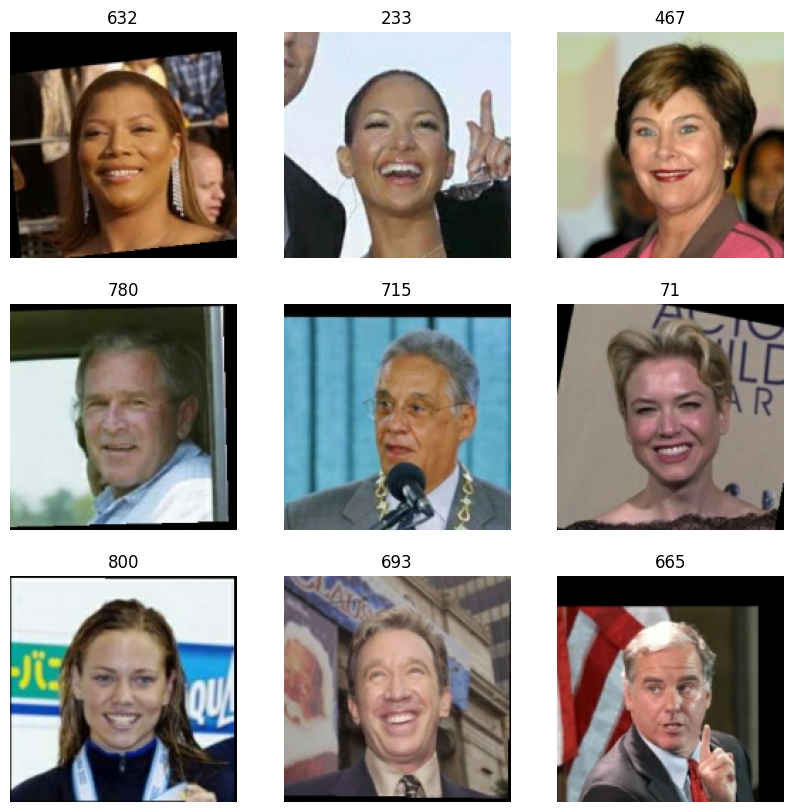

Class distribution in training data: Counter({757: 428, 495: 186, 156: 119, 404: 91, 129: 85, 732: 67, 621: 59, 691: 52, 380: 46, 876: 43, 271: 43, 114: 43, 784: 41, 149: 38, 410: 36, 409: 35, 705: 34, 633: 32, 720: 31, 139: 30, 873: 29, 727: 29, 762: 28, 266: 28, 204: 28, 790: 28, 372: 27, 394: 27, 735: 27, 752: 27, 403: 26, 80: 25, 438: 24, 838: 24, 803: 24, 54: 23, 367: 23, 756: 23, 184: 23, 174: 22, 826: 22, 138: 21, 127: 21, 740: 20, 143: 19, 774: 19, 541: 19, 175: 18, 105: 18, 625: 18, 150: 18, 33: 18, 300: 18, 654: 18, 59: 18, 573: 17, 510: 17, 812: 17, 69: 16, 196: 16, 40: 15, 519: 15, 677: 15, 622: 15, 765: 15, 212: 15, 857: 15, 634: 14, 563: 14, 868: 14, 713: 14, 730: 14, 183: 14, 617: 14, 652: 14, 250: 13, 557: 13, 15: 13, 808: 13, 284: 13, 232: 13, 402: 13, 506: 13, 522: 13, 719: 12, 151: 12, 390: 12, 679: 12, 415: 12, 681: 12, 238: 12, 342: 12, 103: 12, 528: 12, 885: 12, 290: 12, 640: 12, 743: 12, 350: 11, 201: 11, 851: 11, 787: 11, 223: 11, 82: 11, 878: 11, 739: 11, 301: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn import metrics
from sklearn.metrics import confusion_matrix, top_k_accuracy_score
from collections import Counter

train_dir = r'D:\face_recog\dataset'  # Update with your dataset path
img_size = (160, 160)  # Input size for the model

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123
)

# Load the validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Visualize some training images
class_names = train_dataset.class_names
print(f'Class names: {class_names}')

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

plt.show()

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Check class distribution in the training dataset
class_indices = np.concatenate([y.numpy() for _, y in train_dataset])
class_counts = Counter(np.argmax(class_indices, axis=1))
print(f"Class distribution in training data: {class_counts}")

# Build the model
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    augmented_train_dataset,
    validation_data=validation_dataset,
    epochs=100
)

# Evaluate on validation dataset
loss, accuracy = model.evaluate(validation_dataset)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Make predictions on the validation dataset
predictions = model.predict(validation_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = []
for images, labels in validation_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=-1))

true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = metrics.accuracy_score(true_labels, predicted_classes)
print(f'Accuracy: {accuracy:.2f}')

# Print unique classes and their counts for debugging
unique_true_labels, counts_true = np.unique(true_labels, return_counts=True)
unique_predicted_classes, counts_pred = np.unique(predicted_classes, return_counts=True)

print(f"Unique true labels (count: {len(unique_true_labels)}): {unique_true_labels}")
print(f"Unique predicted classes (count: {len(unique_predicted_classes)}): {unique_predicted_classes}")

# Calculate top-K accuracy
top_k_accuracy = top_k_accuracy_score(true_labels, predictions, k=5, labels=np.arange(len(class_names)))
print(f'Top-5 Accuracy: {top_k_accuracy:.2f}')

# Calculate confusion matrix
confusion_matrix_result = confusion_matrix(true_labels, predicted_classes)
print(confusion_matrix_result)

# Class distribution
unique, counts = np.unique(true_labels, return_counts=True)
print(f"Class distribution in validation data: {dict(zip(unique, counts))}")


In [7]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import models

# Load your trained model (adjust the path to your model if needed)
model = models.load_model('my_model.h5')

# Load the dataset to get the class names
train_dir = r'D:\face_recog\dataset'  # Update with your dataset path
img_size = (160, 160)  # Input size for the model
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123
)

# Get class names from the training dataset
class_names = train_dataset.class_names
print(f'Class names: {class_names}')  # Verify class names

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to preprocess the image for prediction
def preprocess_frame(frame):
    # Convert the frame to RGB (OpenCV captures in BGR format)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Resize the frame to the model's input size
    resized_frame = cv2.resize(rgb_frame, img_size)
    
    # Normalize the image
    normalized_frame = resized_frame / 255.0
    
    # Expand dimensions to match model's input shape (1, 160, 160, 3)
    expanded_frame = np.expand_dims(normalized_frame, axis=0)
    
    return expanded_frame

# Function to predict the class of the frame
def predict_class(frame):
    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)
    
    # Predict using the model
    predictions = model.predict(preprocessed_frame)
    
    # Get the predicted class index
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    
    # Get the corresponding class name
    predicted_class_name = class_names[predicted_class_idx]
    
    return predicted_class_name, predicted_class_idx, predictions

# Start the webcam feed using OpenCV
cap = cv2.VideoCapture(0)  # 0 is the default camera ID

frame_limit = 100  # Define the maximum number of frames to process
frame_count = 0    # Initialize the frame counter

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to grab frame")
        break

    # Convert to grayscale for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

    # Iterate over detected faces
    for (x, y, w, h) in faces:
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Crop the face for prediction
        face_crop = frame[y:y + h, x:x + w]
        
        # Predict the class for the detected face
        predicted_label, predicted_index, predictions = predict_class(face_crop)

        # Display the predicted class name on the frame
        cv2.putText(frame, f'Predicted: {predicted_label}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show the frame with the prediction label
    cv2.imshow('Face Recognition', frame)

    # Increment the frame counter
    frame_count += 1

    # Check if the frame limit has been reached
    if frame_count >= frame_limit:
        print("Frame limit reached. Turning off the camera.")
        break

    # Exit loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()


Found 7606 files belonging to 901 classes.
Using 6085 files for training.
Class names: ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217',